**MUQING WEN, ZHOUYI QIAN**

Spring 2023

CS 443: Bio-inspired Machine Learning

#### Week 1: Natural language processing and word embeddings

# Project 2: Word Embeddings and Self-Organizing Maps (SOMs)

You will train a Skip-gram (word2vec) neural network commonly used in the field of natural language processing (NLP) on text from IMDb user movie reviews. The goal of the network is to predict **context words** (the words surrounding each word in a sentence). After implementing and training the network, you will extract the weights to obtain $H$ dimensional **word embedding** vectors for English words that appeared in the movie reviews. You will continue to leverage TensorFlow to implement and train the Skip-gram neural network on the IMDd dataset.

In the second part of the project (`word_cloud.ipynb`), you will implement a self-organizing map (SOM), a competitive bio-inspired neural network that performs dimensionality reduction on its inputs. This network will learn the nonlinear structure of the IMDb word embeddings (in $H$ dimensions) (*unsupervised learning*) and allow you to visualize the words in a 2D space. Remarkably, words with similar meanings should appear nearby each other, even though the network knows nothing about the definitions of the words!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

import imdb
import word2vec

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.show()
plt.rcParams.update({'font.size': 18})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: Preprocess IMDb review dataset

### 1a. Load in IMDb review data

In the cell below, load in the movie review text data from `imdb_train.csv`. The goal is to get a Python list of length 25,000 (there are 25,000 reviews in the training set), where element $i$ is a single string representing the $i^{th}$ review. You're welcome to do this however you like. I suggest using pandas.

In [2]:
data = pd.read_csv("data/imdb_train.csv", delimiter="\t")

In [3]:
print(data["review"].shape)
review_list = list(data["review"])

(25000,)


### 1b. Extract a subset of the reviews

Select the first 10 reviews (*non-shuffled*) from the dataset for development. You will parameterize this later to make it anything you would like for forthcoming neural network simulations.

In [4]:
first_10_review = review_list[0:10]
print(len(first_10_review))

10


### 1c. Create a corpus

In NLP, we usually define a **corpus**, which is the set of documents from which we're interested in learning. For the IMDb dataset and Skip-gram network, this represents a list of sentences across all the reviews (*from the subset that you selected*).

The problem is that the reviews are chunked by review, not sentence.
- In `imdb.py` implement the `make_corpus` function to build a Python list where elements are sentences, not reviews.
- In the cell below, call `make_corpus` on the 10 reviews, assign the resulting list of sentences as a variable called `corpus` for the below test code to work.

In [5]:
# Your code here
corpus = imdb.make_corpus(first_10_review)
print(f'There are {len(corpus)} sentences in the corpus. There should be 99.')

There are 99 sentences in the corpus. There should be 99.


### 1d. Identify unique words and the vocabulary size

Now that you have a corpus of sentences, let's figure out the **vocabulary size**, defined as the number of unique words in the corpus (across all the sentences).
- In `imdb.py` implement the `find_unique_words` function that returns a list of unique words in the corpus.
- Call this function below on your corpus. Define `vocab_sz` as the vocab size.

In [6]:
# Your code here
unique_words = imdb.find_unique_words(corpus)
vocab_sz = len(unique_words)
print(f'There are {vocab_sz} words in the vocabulary. There should be 1016.')

There are 1016 words in the vocabulary. There should be 1016.


### 1e. Make word ↔ unique word index lookup tables

It will be useful when training the neural network to assign an int code to each unique word in the range `[0, vocab_sz-1]`. In this subtask, create dictionaries to allow you to look up a word by its index and vice versa.

In `imdb.py` implement the following functions:
- `make_word2ind_mapping`: This makes a Python dictionary `word2ind` that allows you to use a word string to look up its int code.
- `make_ind2word_mapping`: This makes a Python dictionary `ind2word` that allows you to use a word int code to look up its word string.

In the below test code, `unique_words` refers to your Python list of unique words in the corpus.

In [7]:
# Make word -> index lookup table
word2ind = imdb.make_word2ind_mapping(unique_words)
ind2word = imdb.make_ind2word_mapping(unique_words)
print(f'If you preserved the order of words, the int code for "robot" is {word2ind["robot"]} and should be 159.')
print(f'If you preserved the order of words, the int code for "fans" is {word2ind["fans"]} and should be 108.')
      
print(f'If you preserved the order of words, the string associated with the int code 100 is {ind2word[100]} and should be call.')
print(f'If you preserved the order of words, the string associated with the int code 200 is {ind2word[200]} and should be buddy.')

If you preserved the order of words, the int code for "robot" is 159 and should be 159.
If you preserved the order of words, the int code for "fans" is 108 and should be 108.
If you preserved the order of words, the string associated with the int code 100 is call and should be call.
If you preserved the order of words, the string associated with the int code 200 is buddy and should be buddy.


### 1f. Make target word and context word sets for training a Skip-gram network

To train the Skip-gram network, we need to create specially-formatted training data and classes.

#### Target words

Each training sample will be a single word in each sentence in the corpus (**target word**). Because the input layer of the network has $M$ units, you will one-hot code each target word: it is coded as a vector of zeros with length `vocab_sz` with a 1 at the position represented by the word's int code. For example, if `tourists` has an int code of 2, then its one-hot vector looks like `[0,0,1,0,0,0,0,....]`.

Because it would consume large, unnecessary amounts of memory to preprocess every target word as a one-hot vector, for now you will represent each target word sample as its *int code* (order in vocabulary). You will convert the samples to one-hot vectors during training when forming mini-batches.

#### Context words

Recall that the goal of Skip-gram is to learn to predict **context words**, words that surround the target word (within a window of $W$ words) in a sentence. For example, if $W=2$, the sentence is `I want to see the new Star Wars movie, how about you?`, and the target word is `the`, then the context words are `[to, see, new, Star]`. Context words play the role of `y` (i.e. there are multiple "classes" per data sample). Eventually, you will represent each target word's set of context words as a "*multi-hot vector*": a vector of length `vocab_sz` with zeros everywhere except there are 1s at all the context word indices. As with target words, you will store the set as int codes for now (for efficiency) and convert to multi-hot vectors when forming mini-batches during training.

#### Todo

In `imdb.py`, implement the `make_target_context_word_lists` function that returns:
1. an ndarray of int coded target words
2. the associated context words, as an ndarray of ndarrays, each containing the int codes for the set of context words associated with the $i^{th}$ target word.

In [8]:
targets_int, contexts_int = imdb.make_target_context_word_lists(corpus, word2ind, vocab_sz)
print(f'Training size: {len(targets_int)}. It should be 2255.')
print(f'The first 10 target words indices are:\n {targets_int[:10]}\nand should be\n [0 1 2 3 4 5 6 7 8 0]')
print(f'The last 10 target words indices are:\n {targets_int[-10:]}\nand should be\n [1012  282 1013 1014  454  275   70   41    7 1015]')
print(f'Second context list is {contexts_int[1]} and should be [0 2 3]')

Training size: 2255. It should be 2255.
The first 10 target words indices are:
 [0 1 2 3 4 5 6 7 8 0]
and should be
 [0 1 2 3 4 5 6 7 8 0]
The last 10 target words indices are:
 [1012  282 1013 1014  454  275   70   41    7 1015]
and should be
 [1012  282 1013 1014  454  275   70   41    7 1015]
Second context list is [0 2 3] and should be [0 2 3]


### 1g. Preprocess the IMDb dataset

Write the function `get_imdb` in `imdb.py` to perform all the steps you've completed above in one shot.

In [9]:
num_reviews = 10
targets_int, contexts_int, unique_words, _ = imdb.get_imdb('data/imdb_train.csv', num_reviews=num_reviews)

print(f'Training size: {len(targets_int)}. It should be 2255.')
print(f'The first 10 target words indices are:\n {targets_int[:10]}\nand should be\n [0 1 2 3 4 5 6 7 8 0]')
print(f'The last 10 target words indices are:\n {targets_int[-10:]}\nand should be\n [1012  282 1013 1014  454  275   70   41    7 1015]')
print(f'Second context list is {contexts_int[1]} and should be [0 2 3]')

vocab_sz = len(unique_words)
print(f'There are {vocab_sz} words in the vocabulary. There should be 1016.')

Training size: 2255. It should be 2255.
The first 10 target words indices are:
 [0 1 2 3 4 5 6 7 8 0]
and should be
 [0 1 2 3 4 5 6 7 8 0]
The last 10 target words indices are:
 [1012  282 1013 1014  454  275   70   41    7 1015]
and should be
 [1012  282 1013 1014  454  275   70   41    7 1015]
Second context list is [0 2 3] and should be [0 2 3]
There are 1016 words in the vocabulary. There should be 1016.


## Task 2: Implement and train Skip-gram network

The network has a MLP-like architecture:

`Input -> Dense (linear act) -> Dense (softmax act)`.

The number of input features (`M`) is the number of words in the vocabulary. The number of neurons in the output layer (`C`) is also the number of words in the vocabulary. So for Skip-gram, the number of input and output neurons are equal (i.e. `M` = `C`).

You will build Skip-gram using the TensorFlow low-level API in `word2vec.py`.

### 2a. Skip-gram constructor and one-hot/multi-hot coding

In the `Skipgram` class:
- Copy-paste your code from `NeuralDecoder` in Project 1 to fill in the `one_hot` method. You will use this to encode each target word (*training sample*) when training the network.

In addition, implement:
- constructor
- `set_wts` and `set_b`
- `multi_hot` method: you will use this to encode the context words associated with each target word (*classes*) when training the network. You can think of the multi-hot coded context words as `y`, but in the case of Skip-gram there are *multiple* classes per sample (i.e. multiple correct answers).

#### Test: one-hot

In [87]:
C = 5
y = np.array([0, 3, 2, 4])
skip = word2vec.Skipgram(1, 1, C)
onehotvecs = skip.one_hot(y, C)
print(f'Your one-hot coding of {y} is:')
tf.print(onehotvecs)
print('and should be:\n[[1 0 0 0 0]\n [0 0 0 1 0]\n [0 0 1 0 0]\n [0 0 0 0 1]]')
print(f'{onehotvecs.dtype=} and should be tf.float32')

Your one-hot coding of [0 3 2 4] is:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
and should be:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 0 1]]
onehotvecs.dtype=tf.float32 and should be tf.float32


#### Test: multi-hot

In [11]:
C = 4
y = np.array([np.array([1]), np.array([3, 1]), np.array([2, 0, 1])], dtype=object)
skip = word2vec.Skipgram(1, 1, C)
multihotvecs = skip.multi_hot(y, C)
print(f'Your multi-hot coding of {y} is:')
tf.print(multihotvecs)
print('and should be:')
print('''[[0 1 0 0]
 [0 1 0 1]
 [1 1 1 0]]''')
print(f'{multihotvecs.dtype=} and should be tf.float32')

Your multi-hot coding of [array([1]) array([3, 1]) array([2, 0, 1])] is:
[[0 1 0 0]
 [0 1 0 1]
 [1 1 1 0]]
and should be:
[[0 1 0 0]
 [0 1 0 1]
 [1 1 1 0]]
multihotvecs.dtype=tf.float32 and should be tf.float32


### 2b. Skip-gram forward pass and loss

Implement and test the `forward` and `loss` methods.

#### Skip-gram loss

Equation for skip-gram loss for the current mini-batch: $$L = \frac{1}{B}  \sum_{i=1}^B  \left ( S_i \times Log\left ( \sum_{j=1}^{C} exp \left ( \text{zNetIn}_{ij} \right ) \right ) - \sum_{k=1}^{C} y_{h_{ik}} \text{zNetIn}_{ik} \right ) $$

**Left term:** $S_i$ is the number of words in the current context window (*remember, this is NOT constant across samples*), $\text{zNetIn}_j$ are the `net_in` values in the Output layer, and the sum over $j$ is a sum over all `net_in` values for a given sample (summing over units coding each word in the vocab)

**Right term:** This is the sum of the Output layer `net_in` values multiplied by each sample's multi-hot class vector to "filter out" only the `net_in` values at neurons coding the correct classes.

#### Test with simple corpus

In [12]:
test_corpus = ["I love neural networks and I love computer science at colby".split()]
test_corpus[0]

['I',
 'love',
 'neural',
 'networks',
 'and',
 'I',
 'love',
 'computer',
 'science',
 'at',
 'colby']

In [13]:
test_unique_words = imdb.find_unique_words(test_corpus)
test_vocab_sz = len(test_unique_words)
# Make word -> index lookup table
test_word2ind = imdb.make_word2ind_mapping(test_unique_words)
test_ind2word = imdb.make_ind2word_mapping(test_unique_words)
print('Your word2ind dictionary should look like:')
print('''{'I': 0,
 'love': 1,
 'neural': 2,
 'networks': 3,
 'and': 4,
 'computer': 5,
 'science': 6,
 'at': 7,
 'colby': 8}''')
print('Yours looks like:')
test_word2ind

Your word2ind dictionary should look like:
{'I': 0,
 'love': 1,
 'neural': 2,
 'networks': 3,
 'and': 4,
 'computer': 5,
 'science': 6,
 'at': 7,
 'colby': 8}
Yours looks like:


{'I': 0,
 'love': 1,
 'neural': 2,
 'networks': 3,
 'and': 4,
 'computer': 5,
 'science': 6,
 'at': 7,
 'colby': 8}

In [14]:
# make the training samples and labels
test_targets_int, test_contexts_int = imdb.make_target_context_word_lists(test_corpus, test_word2ind, test_vocab_sz, context_win_sz=4)
print(f'Training size: {len(test_targets_int)}. It should be 11.')

Training size: 11. It should be 11.


In [15]:
# Define consistent wts/bias so that everyone
# gets consistent test code results
test_y_wts = tf.constant(np.array([[0.2919751, 0.2065665],
       [0.5353907, 0.5612575],
       [0.4166745, 0.8078279],
       [0.4932251, 0.9981292],
       [0.6967351, 0.1253736],
       [0.7098167, 0.6624156],
       [0.5722566, 0.3647535],
       [0.4205183, 0.630057 ],
       [0.913813 , 0.6616472]]), dtype=tf.float32)
test_y_b = tf.constant(np.array([0.2919751, 0.2065665]), dtype=tf.float32)

test_z_wts = tf.constant(np.array([[0.2919751, 0.2065665, 0.5353907, 0.5612575, 0.4166745, 0.8078279,
        0.4932251, 0.9981292, 0.6967351],
       [0.1253736, 0.7098167, 0.6624156, 0.5722566, 0.3647535, 0.4205183,
        0.630057 , 0.913813 , 0.6616472]]), dtype=tf.float32)
test_z_b = tf.constant(np.array([0.2919751, 0.2065665, 0.5353907, 0.5612575, 0.4166745, 0.8078279,
       0.4932251, 0.9981292, 0.6967351]), dtype=tf.float32)

In [16]:
M = test_vocab_sz  # 9
H = 2
C = test_vocab_sz

skip = word2vec.Skipgram(num_feats=M,
                         num_hidden=H,
                         num_classes=C)
skip.set_wts(test_y_wts, test_z_wts)
skip.set_b(test_y_b, test_z_b)

print('Your multi-hot encoding of the context words for all samples:')
test_context_multihot = skip.multi_hot(test_contexts_int, len(test_unique_words))
print(test_context_multihot)
print('and it should be:')
print('''tf.Tensor(
[[0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0.]], shape=(11, 9), dtype=float32)
''')

Your multi-hot encoding of the context words for all samples:
<tf.Variable 'Variable:0' shape=(11, 9) dtype=float32, numpy=
array([[0., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 0., 1., 1., 0., 1., 1.],
       [1., 1., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 0., 0., 0., 1., 1., 1., 0.]], dtype=float32)>
and it should be:
tf.Tensor(
[[0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0.]], sha

In [17]:
a_1 = np.array([[1, 2, 3, 4], [2, 2, 2, 2]])
print(a_1.shape)

a_2 = np.prod(a_1, axis = 0)
print(a_2)

(2, 4)
[2 4 6 8]


In [18]:
# Test forward
test_net_in = skip.forward(skip.one_hot(test_targets_int, test_vocab_sz))
print(f'Your output layer net_in shape is:\n{test_net_in.shape} and should be (11, 9)')
print(f'The first sample net_in is \n{test_net_in[0]}\nand should be')
print('''[0.51427   0.6204398 1.1216979 1.125422  0.8106834 1.4532892 1.0415413
 1.9585133 1.3769419]''')

Your output layer net_in shape is:
(11, 9) and should be (11, 9)
The first sample net_in is 
[0.51427   0.6204398 1.1216979 1.125422  0.8106834 1.4532892 1.0415413
 1.9585133 1.3769419]
and should be
[0.51427   0.6204398 1.1216979 1.125422  0.8106834 1.4532892 1.0415413
 1.9585133 1.3769419]


In [19]:
# Test loss
test_loss = skip.loss(test_net_in, test_context_multihot)
print(f'Your loss is {test_loss:.6f} and it should be 13.284546')

Your loss is 13.284546 and it should be 13.284546


### 2c. Skip-gram fit

Copy-and-paste your code from `extract_at_indices` in Project 1 into the method of the same name in the `Skipgram` class.

Next, write the `fit` method. This method is simpler than what you worked on in Project 1 — there is no validation set and no early stopping (training runs for a fixed number of epochs). This is because our primary goal is to learn the training set well (i.e. overfit) so that we can get good word embeddings.

#### Test training workflow

In the cell below:

- Create a new `Skipgram` network with 10 hidden units and wt standard deviation of 1e-1.
- Fit the model to `test_targets_int`, `test_contexts_int` with 500 epochs of training, batch gradient descent (mini-batch size of 11), and learning rate of 1e-2.

This should take at most seconds to finish.

**If you sampled mini-batches without replacement:** you should see the loss drop to ~9.77-9.78 after about 150 epochs and remain stable for the rest of the simulation (no large jumps).

**If you sampled mini-batches with replacement:** you should see the loss drop slightly from its initial value and fluctuate roughly between 8-12 with substantial variance.
    
If your network works, you should see the loss drop to ~9.77-9.78 after about 150 epochs and remain stable for the rest of the simulation (no large jumps). This should take at most seconds to finish.

In [20]:
print(test_targets_int)
print(test_contexts_int)

[0 1 2 3 4 0 1 5 6 7 8]
[array([1, 2, 3, 4]) array([0, 2, 3, 4, 0]) array([0, 1, 3, 4, 0, 1])
 array([0, 1, 2, 4, 0, 1, 5]) array([0, 1, 2, 3, 0, 1, 5, 6])
 array([1, 2, 3, 4, 1, 5, 6, 7]) array([2, 3, 4, 0, 5, 6, 7, 8])
 array([3, 4, 0, 1, 6, 7, 8]) array([4, 0, 1, 5, 7, 8])
 array([0, 1, 5, 6, 8]) array([1, 5, 6, 7])]


In [21]:
M = 9
H = 10
C = 9
skip_net_1 = word2vec.Skipgram(M, H, C, wt_stdev=0.1)
hist_1 = skip_net_1.fit(test_targets_int, test_contexts_int, mini_batch_sz=11, lr=1e-2, n_epochs=500, print_every=50, verbose=True)

Starting to train network ....
Epoch 0/500, Training Loss: 12.01%.
Epoch 50/500, Training Loss: 10.23%.
Epoch 100/500, Training Loss: 9.81%.
Epoch 150/500, Training Loss: 9.78%.
Epoch 200/500, Training Loss: 9.78%.
Epoch 250/500, Training Loss: 9.77%.
Epoch 300/500, Training Loss: 9.77%.
Epoch 350/500, Training Loss: 9.77%.
Epoch 400/500, Training Loss: 9.77%.
Epoch 450/500, Training Loss: 9.77%.


In [22]:
def plot_train_loss(train_loss, title="Training Loss for Skip-gram", n_samps=None, batch_sz=None):
    x_train = []
    
    for i in range(len(train_loss)):
        i_epoch = int(i/ (n_samps / batch_sz))
        x_train.append(i_epoch)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))

    axes.plot(x_train, train_loss, ".g-", markersize=5, label="Train Loss")

    # Axes.set_xlabel(xlabel)
    axes.set_xlabel("Training Epochs")
    axes.set_ylabel("Loss")

    # axes.set_xticks(x_list)
    axes.set_xticklabels(axes.get_xticks(), rotation=0)

    # frameon: Whether the legend should be drawn on a patch (frame).
    axes.legend(loc="lower left", bbox_to_anchor=(1, 0), frameon=True, edgecolor="black")

    axes.set_title(title)
    plt.show()

C:\Users\wenmu\AppData\Local\Temp\ipykernel_24068\877039472.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation=0)


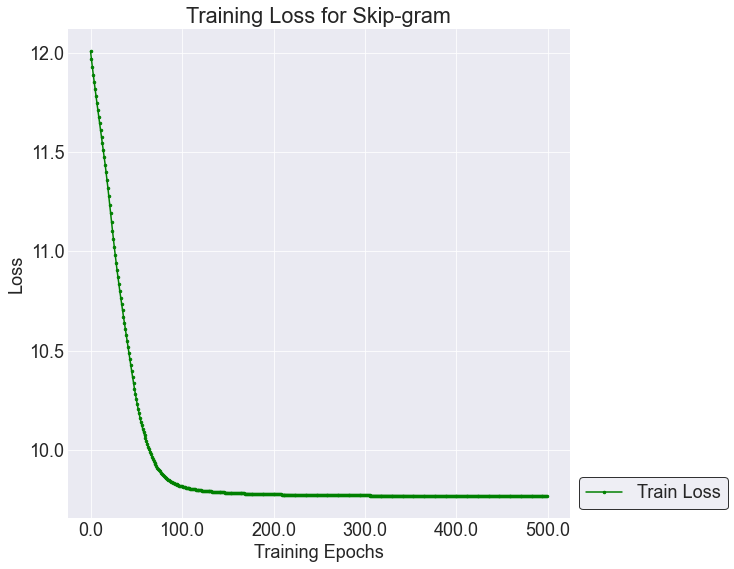

In [23]:
plot_train_loss(hist_1, n_samps=test_targets_int.shape[0], batch_sz=11)

### 2d. Questions

**Question 1:** How do you control the dimension of the word vector embedding with the Skip-gram network?

**Question 2:** What is the relationship between the number of input and output neurons in Skip-gram?

**Answer 1:** 
The number of hidden units (H) controls the dimension of the word embedding vector.
<br> Higher dimension means increased capacity to represent the properties that distinguish each word.
<br> The problem is that data with more than 2 dimensions is hard for humans to interpret. 

**Answer 2:** 
The number of input and output neurons in the Skip-gram network should both be equal to the vocab size (the number of unique words in the corpus).
<br> This is because both the features and classes of each sample (target word) are represented by its context words, which are represented as multi-hot vectors with a binary value for each vocab.

### 2e. Train your model on IMDb data

Set up and train a Skip-gram network on the IMDb movie review data:
- Load in the IMDb data, form a corpus for the training set based on the 1st 15 reviews.
- Train a Skip-gram neural on the corpus. Use a 20-dimensional word embedding (*you can change this later*). 400 epochs should be enough with the default learning rate.
- Create a plot of your training loss over epochs.
    
If all goes well, the training loss should plateau at 11-12. Training should take no longer than a few minutes.

In [24]:
num_reviews = 15

data = pd.read_csv("data/imdb_train.csv",delimiter="\t")
review_list = list(data["review"])
first_n_review = review_list[0: num_reviews]
corpus = imdb.make_corpus(first_n_review)
unique_words = imdb.find_unique_words(corpus)
vocab_sz = len(unique_words)
print(vocab_sz)

1284


In [25]:
word2ind = imdb.make_word2ind_mapping(unique_words)
ind2word = imdb.make_ind2word_mapping(unique_words)

targets_int, contexts_int = imdb.make_target_context_word_lists(corpus, word2ind, vocab_sz)

targets_int, contexts_int, unique_words, _ = imdb.get_imdb('data/imdb_train.csv', num_reviews=num_reviews)

In [26]:
M = vocab_sz
H = 20
C = vocab_sz
net = word2vec.Skipgram(M, H, C, wt_stdev=0.1)
hist_2 = net.fit(test_targets_int, test_contexts_int, mini_batch_sz=11, lr=1e-2, n_epochs=400, print_every=50, verbose=True)

Starting to train network ....
Epoch 0/400, Training Loss: 39.18%.
Epoch 50/400, Training Loss: 11.44%.
Epoch 100/400, Training Loss: 10.74%.
Epoch 150/400, Training Loss: 10.12%.
Epoch 200/400, Training Loss: 9.89%.
Epoch 250/400, Training Loss: 9.83%.
Epoch 300/400, Training Loss: 9.80%.
Epoch 350/400, Training Loss: 9.79%.


C:\Users\wenmu\AppData\Local\Temp\ipykernel_24068\877039472.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticks(), rotation=0)


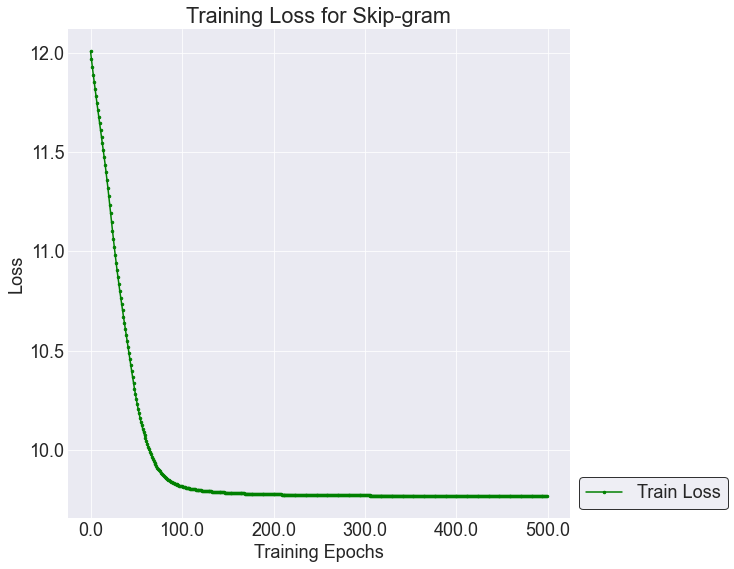

In [27]:
plot_train_loss(hist_1, n_samps=test_targets_int.shape[0], batch_sz=11)

### 2f. Get word embedding vectors

In the `Skipgram` class, implement:

- the `get_word_vector` method that allows us to get the embedding vector for a single word from the trained network.
- the `get_all_word_vectors` method that allows us to get all word embedding vectors from a list passed in to the trained network.

Run the following code to test and save off the IMDb word embeddings. *Adjust variable names as needed to match your naming scheme.*

#### Test `get_word_vector`

In [28]:
print(f'The shape of one of your word vectors are {net.get_word_vector(word2ind, "james").shape} and should be (20,)')
print(f'The word vector for "james" looks like:\n{net.get_word_vector(word2ind, "james")}')

The shape of one of your word vectors are (20,) and should be (20,)
The word vector for "james" looks like:
[-0.0655602  0.0514245  0.0493176 -0.0625544 -0.1012125 -0.105802
 -0.0969051  0.0609805 -0.1020139 -0.0293567  0.1440273  0.1508894
  0.0621092  0.0368279  0.1180196  0.0233555 -0.1172675 -0.027708
 -0.0596733  0.1191935]


#### Test `get_all_word_vectors`

In [29]:
word_vecs = net.get_all_word_vectors(word2ind, unique_words)
print(f'Shape of word vectors: {word_vecs.shape} and should be (1284, 20)\n(for 15 reviews and embedding sz of 20)')

Shape of word vectors: (1284, 20) and should be (1284, 20)
(for 15 reviews and embedding sz of 20)


### 2g. Save the word vectors and unique word strings for visualization

In the next notebook (`word_cloud.ipynb`), you will implement a self-organizing map (SOM) to visualize your IMDb word vectors. The number of reviews that you include in the training set and the hyperparameters used when training the Skip-gram network (e.g.  embedding dimension) will affect the quality of the visualization. To start, you could use the 15 reviews and training configuration from above. **If you decide to make changes, copy and paste your IMDb preprocessing and network training code below and modify it there (so that the above test still produces the expected results).**

Run the following code to export the word vectors and unique words to the `results` folder. Change variable names as needed.

In [30]:
np.save('results/imdb_word_vectors', word_vecs)
np.save('results/imdb_word_strings', unique_words)

In [33]:
print(unique_words[:100])

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'mj', "i've", 'started', 'listening', 'to', 'his', 'music', 'watching', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'wiz', 'moonwalker', 'again', 'maybe', 'i', 'just', 'want', 'get', 'a', 'certain', 'insight', 'into', 'guy', 'who', 'thought', 'was', 'really', 'cool', 'in', 'eighties', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', 'part', 'biography', 'feature', 'film', 'which', 'remember', 'see', 'cinema', 'when', 'it', 'originally', 'released', 'some', 'of', 'has', 'subtle', 'messages', 'about', "mj's", 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drugs', 'are', 'bad', "m'kay", 'br', 'visually', 'impressive', 'but', 'course', 'michael', 'jackson', 'so', 'unless', 'you', 'remotely', 'like', 'anyway', 'then', 'hate', 'find', 'boring', 'may']


### Extension 1: Predict Words Surrounding Each Target Words
I added a "predict" method in the Skip-gram network.
<br> It takes an int-coded word as input, and returns the index of the words with the top-10 highest z_net_in values as context words.

In [101]:
def target_to_int(target, dict1):
    if target in dict1:
        return [dict1[target]]
    else:
        print("dictionary does not contain target word.")

def int_to_words(list1, dict2):
    words = []
    # print(list1)
    for i in list1[0]:
        words.append(dict2[i])
    return words

def predict(word, trained_net, dict1, dict2):
    word_ind = target_to_int(word, dict1)
    
    pred = trained_net.predict(word_ind)
    
    pred = int_to_words(pred, dict2)
    return pred

predict("cinema", net, word2ind, ind2word)

['brother',
 'become',
 'funny',
 'tribute',
 "he's",
 'try',
 "wells'",
 'previous',
 'u',
 'barrel']

#### Test "Predict" on Test Set

In [104]:
data = pd.read_csv("data/imdb_test.csv", delimiter="\t")

print(data["review"].shape)
review_list = list(data["review"])

first_10_review = review_list[0:10]
print(len(first_10_review))

# Your code here
corpus = imdb.make_corpus(first_10_review)
print(f'There are {len(corpus)} sentences in the corpus.')

unique_words = imdb.find_unique_words(corpus)
vocab_sz = len(unique_words)
print(f'There are {vocab_sz} words in the vocabulary.')

print(unique_words[:100])

(25000,)
10
There are 98 sentences in the corpus.
There are 734 words in the vocabulary.
['naturally', 'in', 'a', 'film', "who's", 'main', 'themes', 'are', 'of', 'mortality', 'nostalgia', 'and', 'loss', 'innocence', 'it', 'is', 'perhaps', 'not', 'surprising', 'that', 'rated', 'more', 'highly', 'by', 'older', 'viewers', 'than', 'younger', 'ones', 'however', 'there', 'craftsmanship', 'completeness', 'to', 'the', 'which', 'anyone', 'can', 'enjoy', 'pace', 'steady', 'constant', 'characters', 'full', 'engaging', 'relationships', 'interactions', 'natural', 'showing', 'you', 'do', 'need', 'floods', 'tears', 'show', 'emotion', 'screams', 'fear', 'shouting', 'dispute', 'or', 'violence', 'anger', "joyce's", 'short', 'story', 'lends', 'ready', 'made', 'structure', 'as', 'perfect', 'polished', 'diamond', 'but', 'small', 'changes', 'huston', 'makes', 'such', 'inclusion', 'poem', 'fit', 'neatly', 'truly', 'masterpiece', 'tact', 'subtlety', 'overwhelming', 'beauty', 'this', 'movie', 'disaster', 'with

In [105]:
predict("violence", net, word2ind, ind2word)

['try',
 'tribute',
 'funny',
 'become',
 'brother',
 'are',
 'playfully',
 "he's",
 'avoid',
 'about']